In [1]:
# https://github.com/Shivampanwar/Bert-text-classification/blob/master/XLNet/xlnet_experimentation.ipynb

In [2]:
pip install pytorch-transformers


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf




In [4]:
from __future__ import print_function
import ipywidgets as widgets
import re
from sklearn.preprocessing import LabelEncoder

In [5]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [6]:
df = pd.read_csv("data_transformer.csv")

In [7]:
df.head()

,text_clean,target
0,from a gender perspective paulgaard points out...,5
1,the average figure also masks large difference...,3
2,the israel oceanographic and limnological rese...,6
3,previous chapters have discussed ways to make ...,2
4,prescription rates appear to be higher where l...,8


In [8]:
sentences = df['text_clean'].values

In [9]:
# Simple cleaning of text ahead of summarisation

def clean_text(text):
    text = text.encode("ascii", errors="ignore").decode("ascii") #remove non-ascii, Chinese characters
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\n\n", " ", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(' +',' ', text).strip() # get rid of multiple spaces and replace with a single
    return text


In [10]:
df["text_clean"] = df["text_clean"].apply(lambda text:clean_text(str(text)))

<Axes: xlabel='target', ylabel='count'>

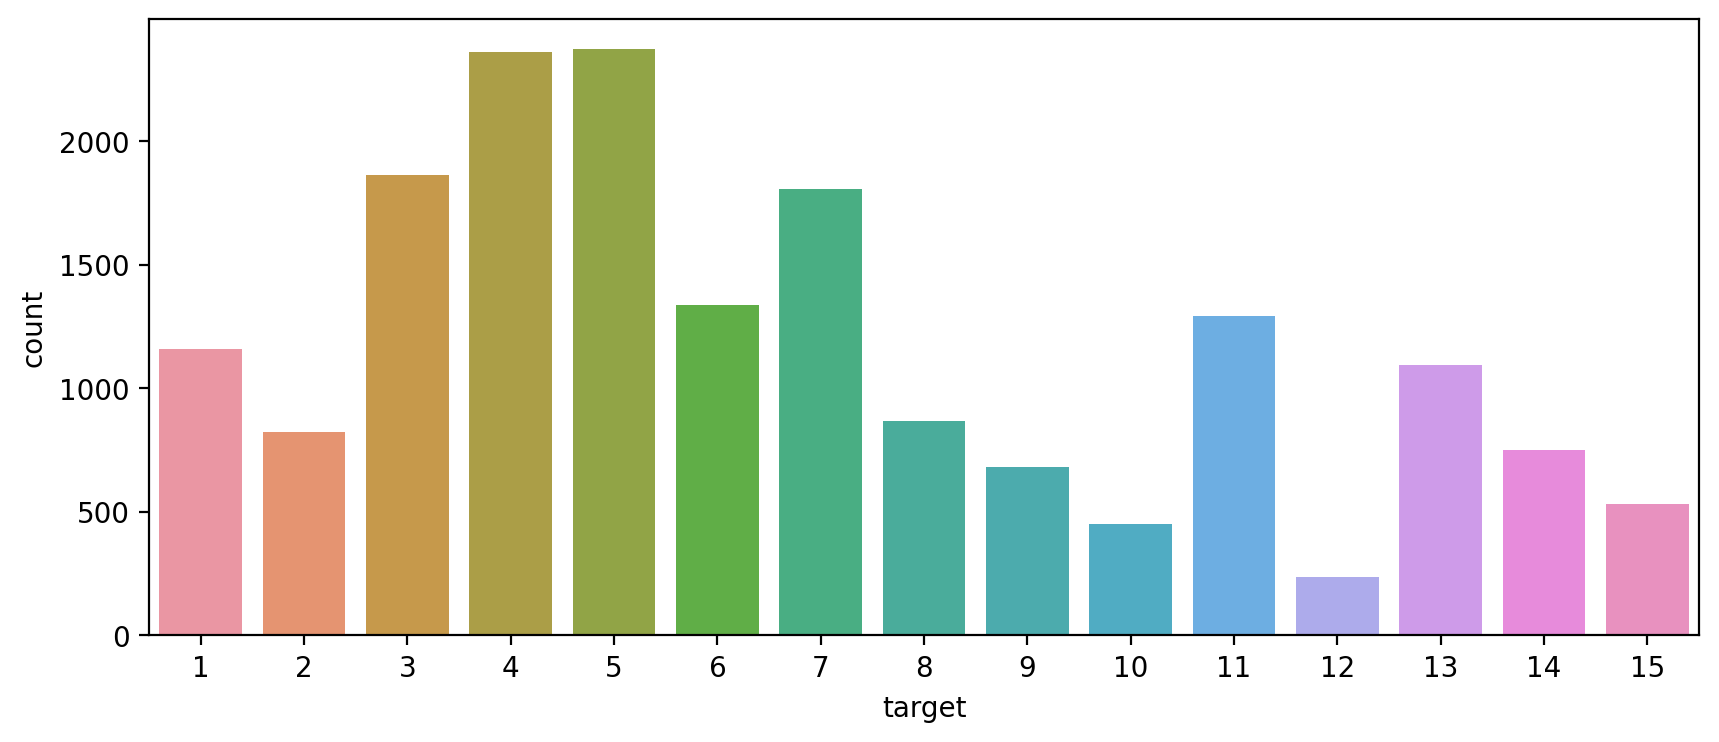

In [11]:
plt.figure(figsize=(10,4),dpi=200)
sns.countplot(x='target',data=df)

In [12]:
X_train,X_test ,y_train,y_test = train_test_split(df['text_clean'], 
                                                  df['target'], random_state = 42, test_size = 0.2)

In [13]:
from transformers import TFXLNetModel, XLNetTokenizer
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

In [14]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,         
        return_token_type_ids=False,
        padding='max_length',
        max_length=maxlen, 
        truncation=True
    )
    
    return np.array(enc_di['input_ids'])


In [15]:
Xtrain_encoded = regular_encode(X_train.astype('str'), xlnet_tokenizer, maxlen=300)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=16,dtype = 'int32')
Xtest_encoded = regular_encode(X_test.astype('str'), xlnet_tokenizer, maxlen=300)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=16,dtype = 'int32')

In [17]:
from imblearn.over_sampling import RandomOverSampler

In [18]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [19]:
Xtrain_encoded,ytrain_encoded = oversample.fit_resample(Xtrain_encoded,ytrain_encoded)

In [21]:
Xtest_encoded,ytest_encoded = oversample.fit_resample(Xtest_encoded,ytest_encoded)

In [22]:
def create_model_xlnet(xlnet_model):
    word_inputs = tf.keras.Input(shape=(300,), name='word_inputs', dtype='int32')

    
    xlnet = TFXLNetModel.from_pretrained(xlnet_model)
    xlnet_encodings = xlnet(word_inputs)[0]

    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
     
    outputs = tf.keras.layers.Dense(15, activation='softmax', name='outputs')(doc_encoding)

    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [23]:
xlnet = create_model_xlnet(xlnet_model)
xlnet.summary()

C:\Users\Joseph Fares\AppData\Roaming\Python\Python310\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 300)]             0         
                                                                 
 tfxl_net_model (TFXLNetMode  TFXLNetModelOutput(last_  116718336
 l)                          hidden_state=(None, 300,            
                              768),                              
                              mems=((300, None, 768),            
                              (300, None, 768),                  
                              (300, None, 768),                  
                              (300, None, 768),                  
                              (300, None, 768),                  
                              (300, None, 768),                  
                              (300, None, 768),                  
                              (300, None, 768),              

In [24]:
#creating the training and testing dataset.
BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [25]:
#training for 2 epochs
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = xlnet.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=2
)

Epoch 1/2
987/987 [==============================] - 30649s 31s/step - loss: 1.3041 - accuracy: 0.6161
Epoch 2/2
987/987 [==============================] - 84878s 86s/step - loss: 0.4344 - accuracy: 0.8835


In [26]:
import transformers 

In [27]:
from tensorflow import keras

In [28]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
xlnet.save("xlnet_model.h5")


In [29]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("xlnet_model.h5",  custom_objects={"TFXLNetModel": transformers.TFXLNetModel})

In [30]:
preds = reconstructed_model.predict(test_dataset)

275/275 [==============================] - 3034s 11s/step


In [31]:
pred_classes = np.argmax(preds, axis = 1)
pred_classes

array([ 2,  6, 10, ...,  9, 11,  9], dtype=int64)

In [32]:
test_classes = np.argmax(ytest_encoded, axis = 1)
test_classes

array([ 2,  6, 10, ...,  9,  9,  9], dtype=int64)

In [33]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [34]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(test_classes, pred_classes)}")

Accuracy is 0.8410490307867731


In [35]:
print(f"Precision is {sklearn.metrics.precision_score(test_classes, pred_classes,average= 'weighted')}")

Precision is 0.84002659694436


In [36]:
print(f"Recall is {sklearn.metrics.recall_score(test_classes, pred_classes,average= 'weighted')}")

Recall is 0.8410490307867731


In [37]:
print(f"F1 Score is {sklearn.metrics.f1_score(test_classes, pred_classes,average= 'weighted')}")

F1 Score is 0.8340745788045051


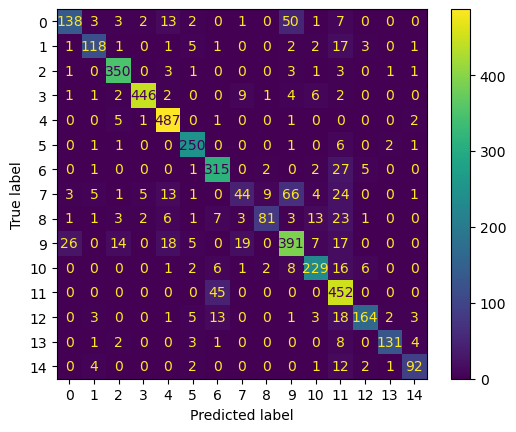

In [39]:
cm = confusion_matrix(test_classes, pred_classes)
ConfusionMatrixDisplay(cm).plot()

In [40]:
from sklearn.preprocessing import label_binarize 

In [41]:
y_test = label_binarize(test_classes,classes=np.unique(test_classes))
y_pred = preds

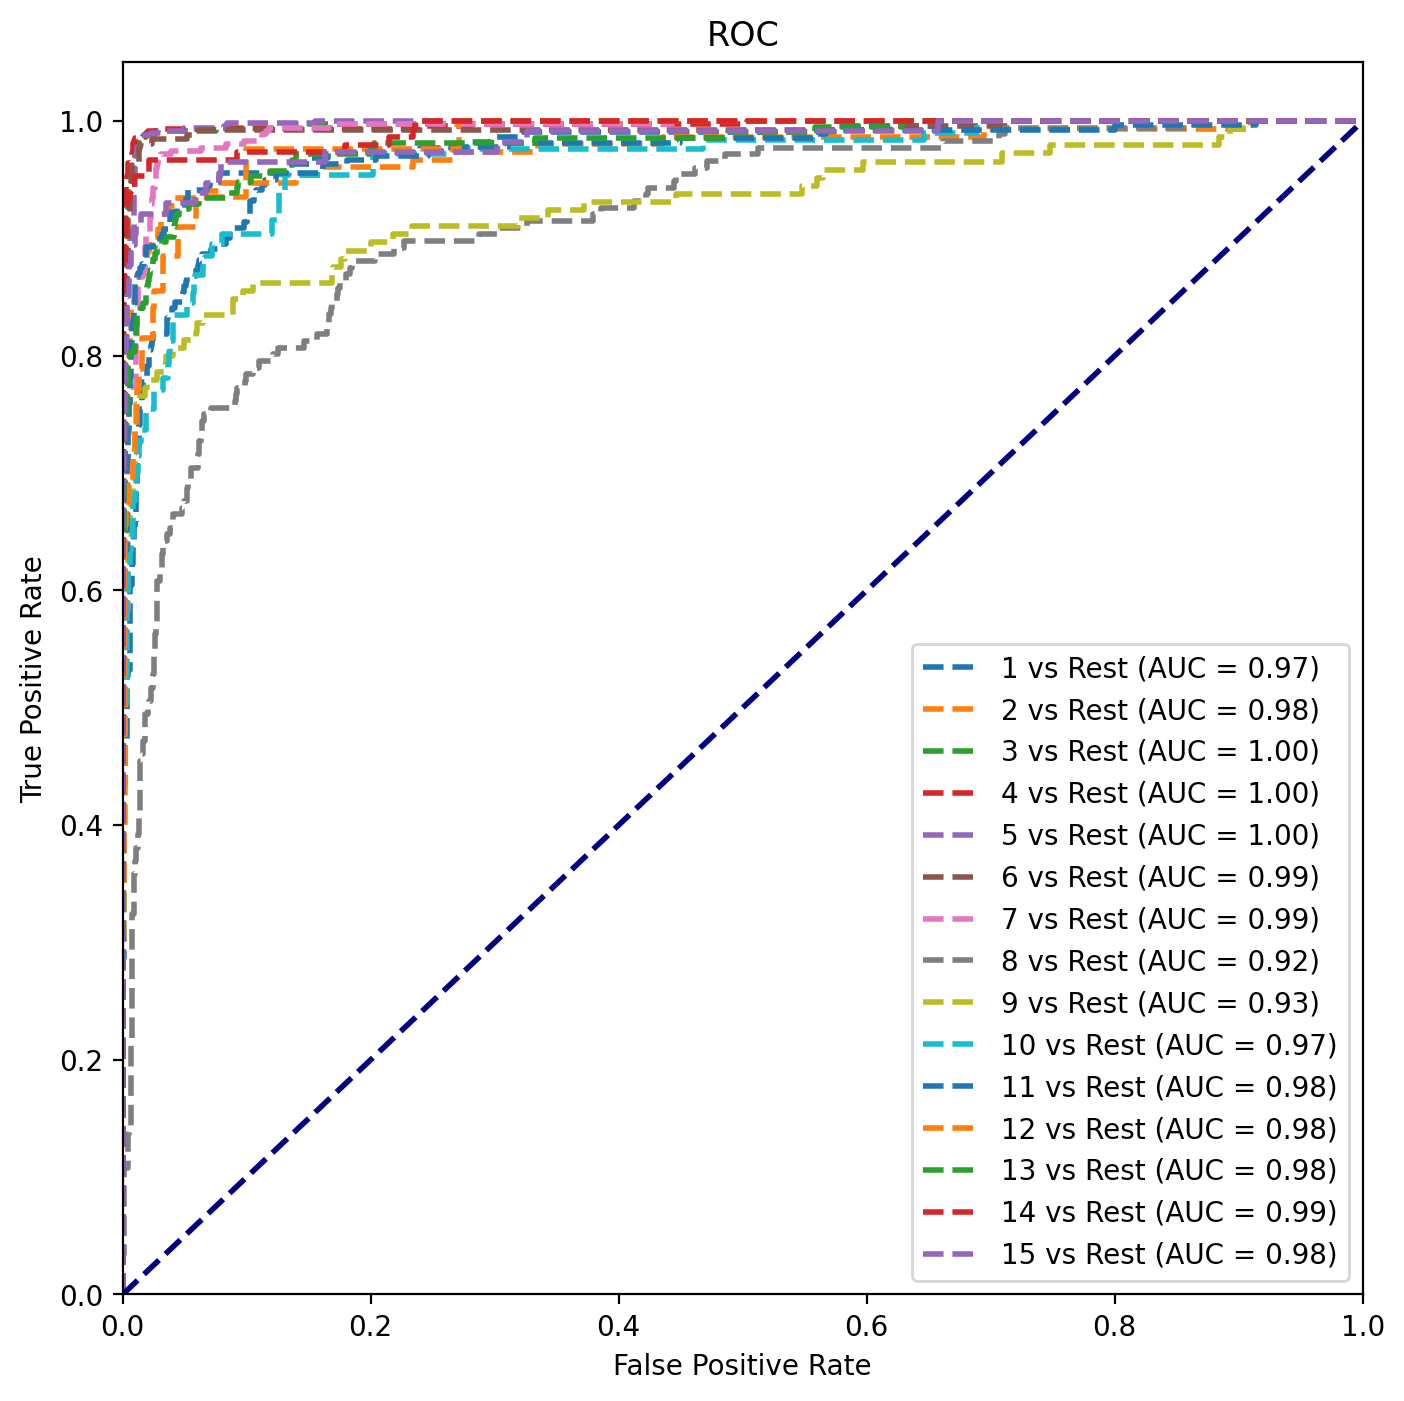

In [42]:
from sklearn.metrics import roc_curve, auc

# Learn to predict each class against the other


n_classes = 15 # number of class
plt.figure(figsize=(8,8),dpi=200)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i], )
    roc_auc[i] = auc(fpr[i], tpr[i])    
    
    lw = 2 # line_width
    plt.plot(fpr[i], tpr[i], linestyle='--',
    lw=lw, label='%s vs Rest (AUC = %0.2f)' % (i+1,roc_auc[i])) # Drawing Curve according to 15. class 
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [43]:
test_df = pd.read_excel("test_dataset_updated.xlsx")

In [44]:
test_df.head()

,News Summary,OSDG,OSDG Label
0,agricultural engineer eduardo assad has devot...,Climate Action,13
1,agricultural organizations are joining forces...,Zero Hunger,2
2,aim4c coalition pledged to accelerate innovat...,Climate Action,13
3,alaa abd el fattah one of egypts most high pr...,Climate Action,13
4,alcazar energy partners ii slp scsp aep ii br...,Affordable and Clean Energy,7


In [45]:
news = test_df['News Summary']
labels = test_df['OSDG Label']

In [46]:
def encode_news(new, tokenizer):
    news_encoded = regular_encode(new.astype('str'), tokenizer, maxlen=300)
    news_dataset = (tf.data.Dataset.from_tensor_slices(news_encoded).batch(BATCH_SIZE))
    return news_dataset    

In [47]:
news_prepared = encode_news(news,xlnet_tokenizer)

In [48]:
pred_class = reconstructed_model.predict(news_prepared)

111/111 [==============================] - 1279s 12s/step


In [49]:
pred_classes = np.argmax(pred_class, axis = 1)+1
pred_classes

array([13,  2, 13, ..., 13, 13,  2], dtype=int64)

In [50]:
result_df = pd.DataFrame({'news':test_df['News Summary'],'true_category':test_df['OSDG Label'], 'predicted_category':pred_classes})
result_df

,news,true_category,predicted_category
0,agricultural engineer eduardo assad has devot...,13,13
1,agricultural organizations are joining forces...,2,2
2,aim4c coalition pledged to accelerate innovat...,13,13
3,alaa abd el fattah one of egypts most high pr...,13,13
4,alcazar energy partners ii slp scsp aep ii br...,7,7
...,...,...,...
1770,Young activists from outside the country espec...,13,13
1771,Youth climate activism is bearing fruit our an...,13,13
1772,Youth climate activist greta thunberg has a bo...,13,13
1773,Zambia's environment minister collins nzovu de...,13,13


In [51]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.7701408450704226


In [52]:
print(f"Precision is {sklearn.metrics.precision_score(result_df['true_category'], result_df['predicted_category'],average= 'weighted')}")

Precision is 0.8821625326106416


In [53]:
print(f"Recall is {sklearn.metrics.recall_score(result_df['true_category'], result_df['predicted_category'],average= 'weighted')}")

Recall is 0.7701408450704226


In [54]:
print(f"F1-Score is {sklearn.metrics.f1_score(result_df['true_category'], result_df['predicted_category'],average= 'weighted')}")

F1-Score is 0.7918476155593366


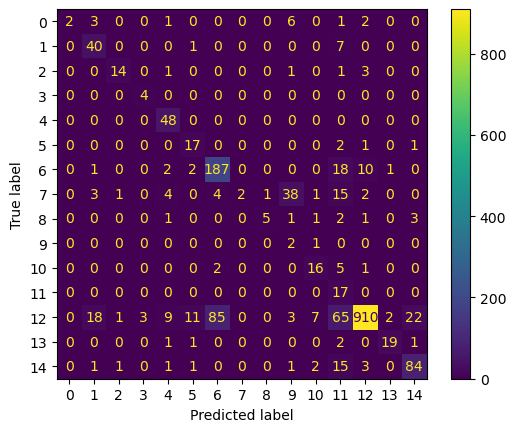

In [55]:
cm = confusion_matrix(result_df['true_category'], result_df['predicted_category'])
ConfusionMatrixDisplay(cm).plot()

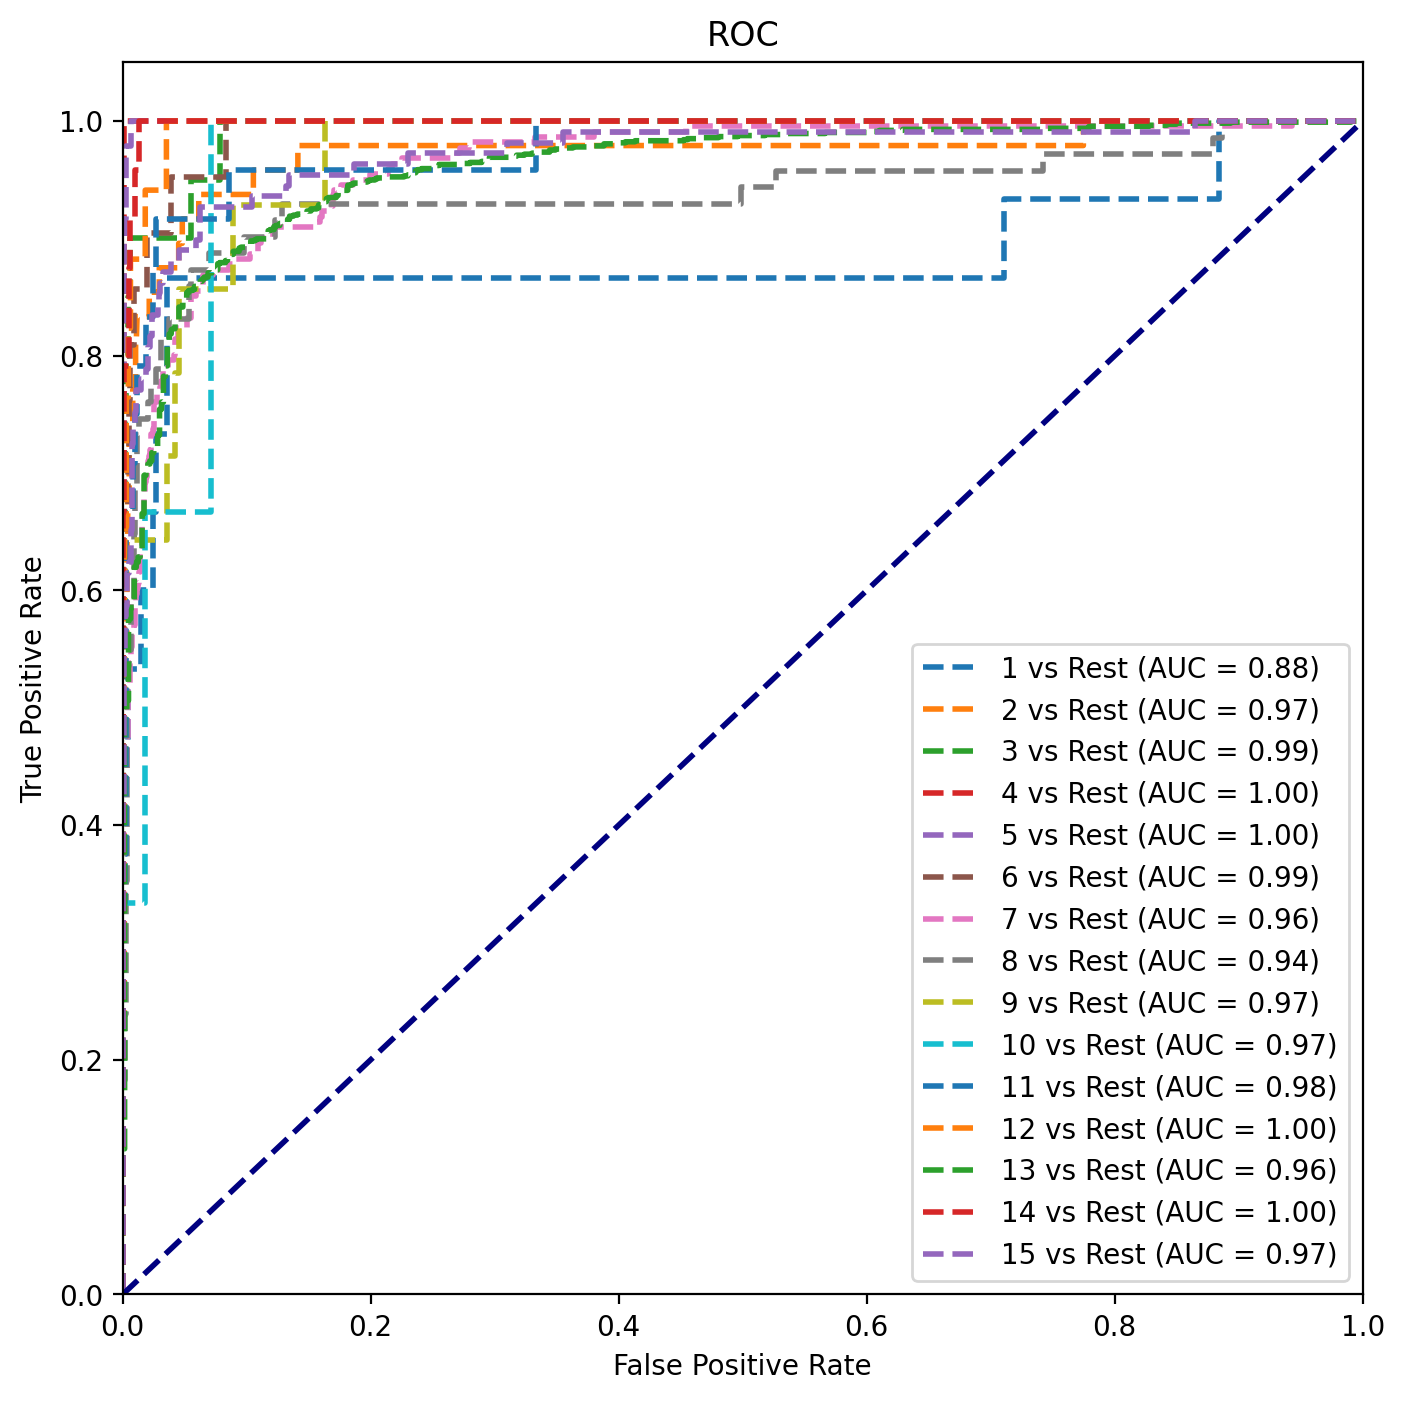

In [56]:
# Learn to predict each class against the other
y_test = label_binarize(result_df['true_category'],classes=np.unique(result_df['true_category']))
y_pred = pred_class

n_classes = 15 # number of class
plt.figure(figsize=(8,8),dpi=200)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i], )
    roc_auc[i] = auc(fpr[i], tpr[i])    
    
    lw = 2 # line_width
    plt.plot(fpr[i], tpr[i], linestyle='--',
    lw=lw, label='%s vs Rest (AUC = %0.2f)' % (i+1,roc_auc[i])) # Drawing Curve according to 15. class 
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [58]:
 # saving the excel
file_name = 'xlnet_results.xlsx'
result_df.to_excel(file_name)